### Experiement using batch size of 26048

In [ ]:
#these are our libraries
from dfencoder import AutoEncoder
import numpy as np
import pandas as pd

#and, for pretty visualiations...
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%config InlineBackend.figure_format = 'retina'
import torch

This dataset contains information about 32,561 adults (in the training set), with a number of features.

Traditionally, the target variable is "salary," a binary feature with "<50k" and ">=50k" as its two values. For this now, we'll treat this column as we do all the others.

In [2]:
#load and look at the data
df = pd.read_csv('https://github.com/AlliedToasters/dfencoder/raw/master/adult.csv')

#this dataset contains nulls and ' ?'. Let's make these all nulls.
df = df.applymap(lambda x: np.nan if x==' ?' else x)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k



Validation on Hold-Out Set
Even in unsupervised learning, it's a good idea to do a train/validation split during training. 
This will help you fine-tune your model and avoid overfitting. Let's hold out 20% of the examples.

In [3]:
train = df.sample(frac=.8, random_state=42)
test = df.loc[~df.index.isin(train.index)]

X_train = train
X_val = test

In [4]:
model = AutoEncoder(
    encoder_layers = [512, 512, 512], #model architecture
    decoder_layers = [], #decoder optional - you can create bottlenecks if you like
    activation='relu',
    swap_p=0.2, #noise parameter
    lr = 0.01,
    lr_decay=.99,
    batch_size=  26048, #512
    logger='ipynb', #special logging for jupyter notebooks
    verbose=False,
    optimizer='sgd',
    scaler='gauss_rank', #gauss rank scaling forces your numeric features into standard normal distributions
    min_cats=3 #Define cutoff for minority categories, default 10
)

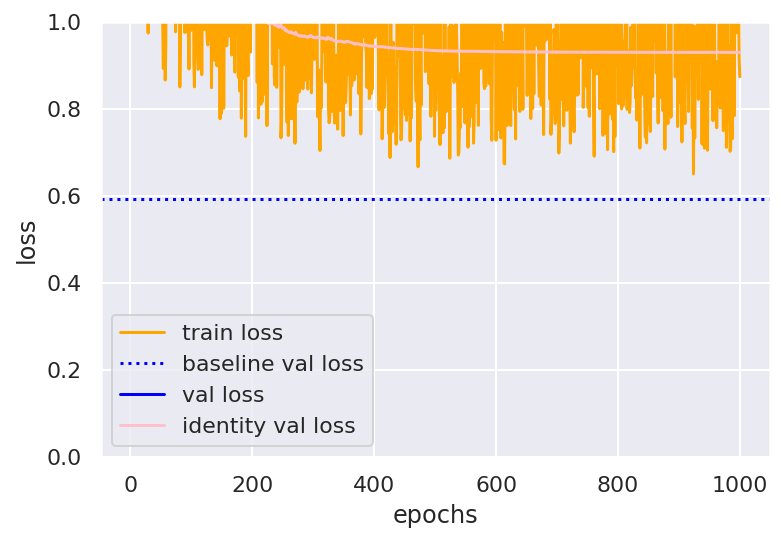

In [7]:
model.fit(X_train, epochs=1000, val=X_val)

In [8]:

z = model.get_deep_stack_features(X_val)
print(z.shape)
print(z[0, :])

torch.Size([6512, 1536])
tensor([0.5189, 0.0000, 0.0000,  ..., 0.1739, 0.4351, 0.0000], device='cuda:0')


In [9]:
X_train.salary.unique()

array(['<50k', '>=50k'], dtype=object)

In [10]:
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import f1_score
import numpy as np
import torch
import tqdm

class ClassifierModel(torch.nn.Module):
    """A simple classifier neural network."""
  
    def __init__(self, *args, **kwargs):
        super(ClassifierModel, self).__init__(*args, **kwargs)
        self.input_dropout = torch.nn.Dropout(.1)
        self.input_layer = torch.nn.Linear(1536, 512)
        self.dropout = torch.nn.Dropout(.5)
        self.dense = torch.nn.Linear(512, 512)
        self.output = torch.nn.Linear(512, 1)

    def forward(self, x):
        x = self.input_dropout(x)
        x = self.input_layer(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.relu(x)

        x = self.output(x)
        x = torch.sigmoid(x)
        return x
    
    
classifier = ClassifierModel().to("cuda:0")

optim = torch.optim.Adam(
    classifier.parameters(),
    weight_decay=.01
)

decay = torch.optim.lr_scheduler.ExponentialLR(optim, .99)

loss = torch.nn.modules.loss.BCELoss()

def do_step(classifier, optim, z, target, loss):
    pred = classifier(z)
    target = torch.tensor(target).float().reshape(-1, 1).to("cuda:0")
    loss_ = loss(pred, target)
    amnt = loss_.item()
    loss_.backward()
    optim.step()
    optim.zero_grad()
    return amnt

def do_evaluation(classifier, z, target, loss):
    with torch.no_grad():
        pred = classifier(z)
        probs = pred.cpu().numpy().reshape(-1)
        predictions = np.where(probs > .5, 1, 0)

        accuracy = np.where(target==predictions, 1, 0).sum()/len(predictions)
        f1 = f1_score(target, predictions)

        target_ = torch.tensor(target).float().reshape(-1, 1).to("cuda:0")
        loss_ = loss(pred, target_)
        return loss_.item(), accuracy, f1

  
batch_size = 256
n_updates = (len(X_train)//batch_size) + 1

n_epochs = 1000

#To extract features, we'll set the target column on the input
#equal to the majority class: <50k

X_train2 = X_train.copy()
X_train2['salary'] = ['<50k' for _ in X_train2['salary']]
z_train = model.get_deep_stack_features(X_train2)

Y_train = np.where(X_train['salary'].values == '<50k', 0, 1)

X_test2 = X_val.copy()
X_test2['salary'] = ['<50k' for _ in X_test2['salary']]
z_test = model.get_deep_stack_features(X_test2)
Y_test = np.where(X_val['salary'].values == '<50k', 0, 1)

for j in range(n_epochs):
    if j % 100 == 0:
      print(f'{j} epochs complete...')
    for i in range(n_updates):
        step = i
        start = int((step) * batch_size)
        stop = int((step+1) * batch_size)
        in_ = z_train[start:stop]
        target = Y_train[start:stop]
        do_step(classifier, optim, in_, target, loss)
    decay.step()
    bce_loss, accuracy, f1 = do_evaluation(classifier, z_test, Y_test, loss)
print('\nFinal results: ')
print('validation loss: ', round(bce_loss, 4))
print('validation accuracy: ', round(accuracy, 3))
print('validation f1 score: ', round(f1, 3))

0 epochs complete...
100 epochs complete...
200 epochs complete...
300 epochs complete...
400 epochs complete...
500 epochs complete...
600 epochs complete...
700 epochs complete...
800 epochs complete...
900 epochs complete...

Final results: 
validation loss:  0.3298
validation accuracy:  0.852
validation f1 score:  0.653


In [11]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  5% | 63% |


In [12]:
torch.cuda.empty_cache()

In [13]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  6% | 62% |
